<a href="https://colab.research.google.com/github/hiwasaki1712/ml_edu_notes/blob/main/RF_iris_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# アヤメデータをランダムフォレストで分類するサンプル

典型的な例として、超有名データを代表的な手法で分類する流れを紹介する。  
* iris データに RandomForest の教師あり多値分類を適用。
* 各クラスの特徴重要度を観察
* 一般的な方法で学習結果を評価

___
RandomForest  
複数の決定木の多数決で推論する手法。  
データからサンプリングしたサブセットで決定木を学習する過程を繰り返す。  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

irisデータ  
アヤメの花の花弁（petal）とがく（sepal）の長さと幅のデータ



In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, RocCurveDisplay, auc)
from sklearn.inspection import DecisionBoundaryDisplay, permutation_importance


print (np.__version__)
print (pd.__version__)
print (matplotlib.__version__)
print (sklearn.__version__)

1.26.4
2.2.2
3.8.0
1.5.2


In [3]:
### 実験の再現性のため、乱数シードを定義
random_state = 137

In [4]:
# Load sample data
iris = load_iris()

# 説明変数
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)

# 目的変数
df_iris['target'] = iris.target

# 目的変数の名称
target_names_dict = {ii: val for ii, val in enumerate(iris.target_names)}
df_iris['target_name'] = df_iris['target'].map(target_names_dict)

df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


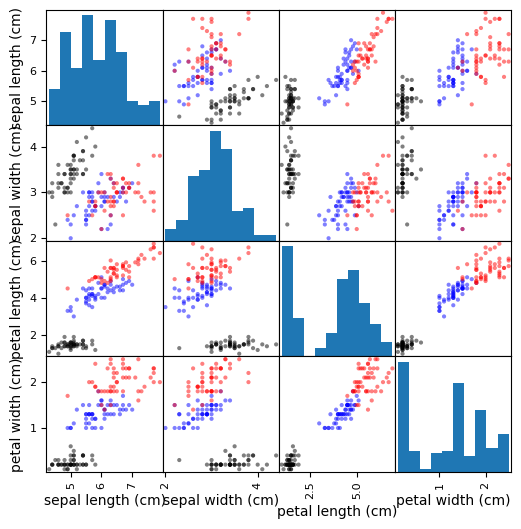

In [5]:
### 各クラスの色を定義
color_dict = {0:'black', 1:'blue', 2:'red'}
color = df_iris['target'].map(color_dict)

### データセットのペアプロットを表示
scatter_matrix(df_iris.drop(columns=['target', 'target_name']),
               color=color,
               figsize=(6,6))
plt.show()

In [8]:
### データセットを train-test 分割
df_train, df_test = train_test_split(df_iris,
                                     test_size=0.3,
                                     stratify=df_iris['target'],
                                     random_state=random_state)

X_train = df_train.drop(columns=['target', 'target_name'])
y_train = df_train['target']
X_test = df_test.drop(columns=['target', 'target_name'])
y_test = df_test['target']

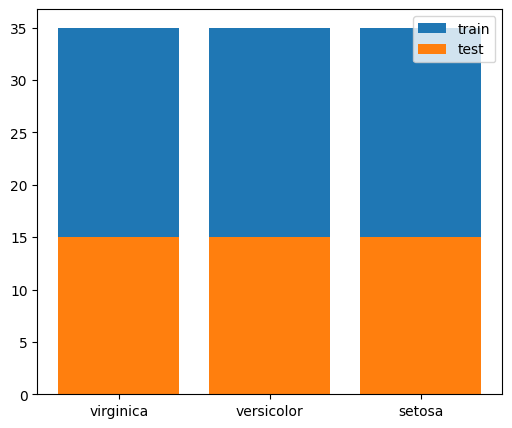

In [9]:
### 分割したデータの各クラスの割合がtrain-testで均等か確認
plt.figure(figsize=(6, 5))
plt.bar(df_train['target_name'].unique(), df_train['target_name'].value_counts(), label='train')
plt.bar(df_test['target_name'].unique(), df_test['target_name'].value_counts(), label='test')
plt.legend()
plt.show()

## 分類

In [12]:
### 分類器を train set で学習
clf = RandomForestClassifier(n_estimators=100,
                            #  max_depth=3,
                             random_state=random_state)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=137)

## 学習結果の評価

###モデル固有の評価・解釈

Random forest は決定木ほどの解釈性は高くないが、特徴量重要度を求めることはできる

In [11]:
### 特徴量重要度を表示
for ii, feat_name in enumerate(X_test.columns):
    print (f'{feat_name:20s}: {clf.feature_importances_[ii]:>.3f}')

sepal length (cm)   : 0.082
sepal width (cm)    : 0.037
petal length (cm)   : 0.477
petal width (cm)    : 0.405


This RF has 100 trees.
Tree 0


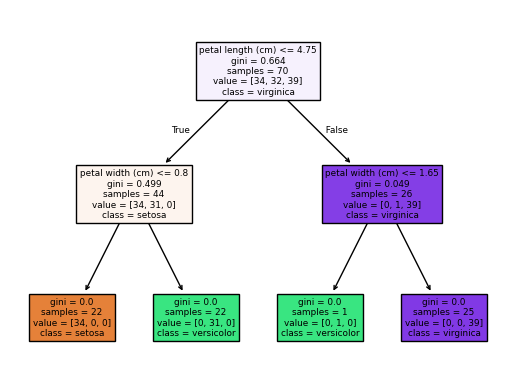

Tree 1


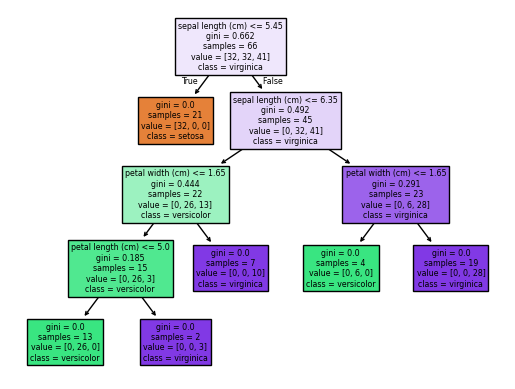

Tree 2


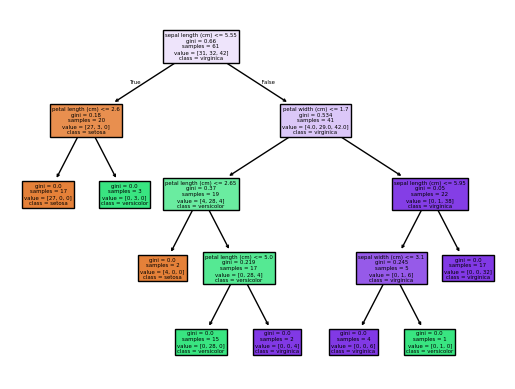

Tree 3


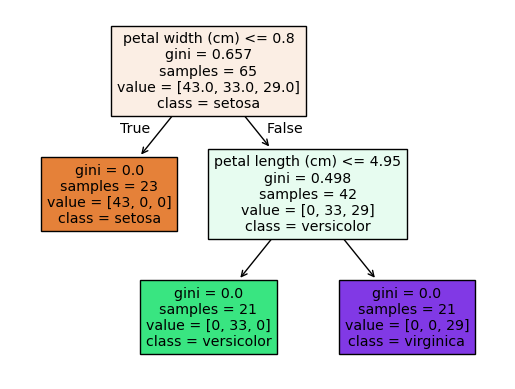

Tree 4


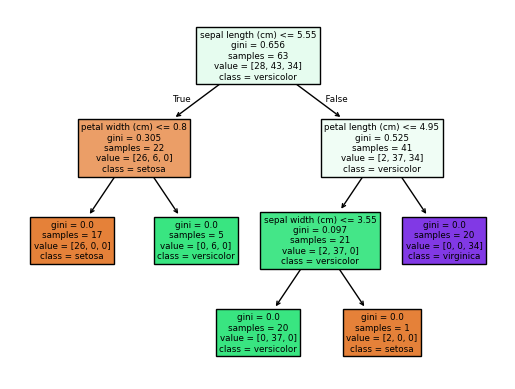

In [13]:
### Random forest 内の tree モデルの樹形図をプロット
print (f'This RF has {len(clf.estimators_)} trees.')

for ii in range(min(len(clf.estimators_), 5)):
    print (f'Tree {ii}')
    plot_tree(clf.estimators_[ii],
              feature_names=iris.feature_names,
              class_names=iris.target_names,
              filled=True)
    plt.show()

Random forest は複数の決定木のアンサンブルモデルであるから、その決定木1個1個を可視化することはできるが、全体としての樹形図は描けない。

###一般的な性能評価

分類モデルの評価でよく使われる評価指標の計算や可視化を行う

In [ ]:
### Show Accuracy for train and test set respectively
print ('Train score:', clf.score(X_train, y_train))
print ('Test score: ', clf.score(X_test, y_test))

Train score: 0.975
Test score:  0.9666666666666667


In [ ]:
### Metricsをサマリ
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



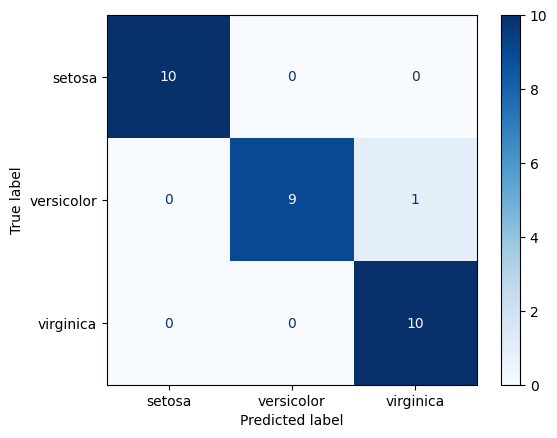

In [ ]:
### 混同行列をプロット
# https://scikit-learn.org/dev/auto_examples/release_highlights/plot_release_highlights_1_5_0.html#sphx-glr-auto-examples-release-highlights-plot-release-highlights-1-5-0-py

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,
                                      display_labels=iris.target_names,
                                      cmap=plt.cm.Blues)
plt.show()

0 setosa
1 versicolor
2 virginica


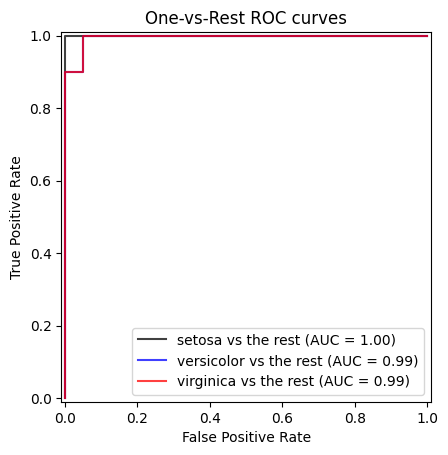

In [ ]:
### ROC カーブをプロット
# https://scikit-learn.org/dev/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

# testセットに対する分類結果（各クラスの確率値）を取得
y_score = clf.predict_proba(X_test)

# 便宜上、正解ラベルをone-hot表現にする
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

ax = plt.gca()

# クラスごとにROCをプロット
for ii, cls_name in enumerate(iris.target_names):
    print (ii, cls_name)
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, ii],
        y_score[:, ii],
        name=f"{cls_name} vs the rest",
        color=color_dict[ii],
        ax=ax,
        # plot_chance_level=True,
        # despine=True,
        alpha=0.75
    )

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves",
)